<a href="https://colab.research.google.com/github/itssofiarce/NLP-2025/blob/main/arce_nlp_tp_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TUIA NLP 2025
TRABAJO PRÁCTICO FINAL

Docentes:
- jpmanson@gmail.com
- alan.geary.b@gmail.com
- constantinoferrucci@gmail.com
- dolores.sollberger@gmail.com


# Implementación de un chatbot con RAG experto en Sagrada

In [ ]:
# Preparación del entorno con lo trabajado en la primer parte del trabajo práctico
import os

REPO_NAME = "sagrada"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/itssofiarce/{REPO_NAME}.git
  os.chdir(REPO_NAME)

In [ ]:
REPO_NAME = "NLP-2025"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/itssofiarce/{REPO_NAME}.git
  os.chdir(REPO_NAME)

# Creación de la base de datos vectorial con la data de Sagrada - Pinecone
Para llevar a cabo esta parte primero deben estar completas estas subtareas


1.   Preprocesamiento de los datos - generar chunks
2.   Instanciar Pinecone
3.   Creación de los embbedings para los chunks de la información
4.   Agregar los indices a Pinecone
5.  Crear la interfaz para encontrar los K fragmentos mas parecidos a la consulta.



## 1. Preprocesamiento de los datos - generar chunks


In [ ]:
!pip install langchain

In [ ]:
from langchain_text_splitters import SpacyTextSplitter
from langchain_core.documents import Document

splitter = SpacyTextSplitter()

In [ ]:
# Preprocesamiento de los datos
def add_metadata(doc, metadata):
  return Document(page_content=doc, metadata=metadata)


def preprocess_documentos(ruta_docs, categoria: str):

  informacion_pinecone = []

  with open(ruta_docs, 'r') as archivo:
    contenido = archivo.read()

  contenido_spliteado = splitter.split_text(contenido)
  chunk_metadata = [add_metadata(chunk, {"categoria": categoria, "num_chunk": num }) for num, chunk in enumerate(contenido_spliteado)]
  informacion_pinecone.extend(chunk_metadata)

  return informacion_pinecone


Como las transcipciones de los videos tienen información y estan dividos por lineas de  --- antes de crearlos en un documento Langchain voy a preprocesar el texto para incluir los datos de las primeras lineas de los textos como metadata


In [ ]:
def procesar_transcripciones_videos(transc_videos):

  transcripciones_pinecone = []

  transcipciones_con_metadata = []
  metadata = {'categoria': 'transcipcion_video',
              'titulo':"",
              'url': "",
              'idioma detectado':"",
              }

  with open(transc_videos, 'r') as transc_videos:
    contenido = transc_videos.read()

  contenido_spliteado = contenido.split("------------------------------------------------------------")

  for transcripcion in contenido_spliteado:

    partes = transcripcion.split("TRANSCRIPCIÓN:")
    try:
        cabecera = partes[0]
        transcripcion_texto = partes[1]
    except IndexError:
        # Si no hay transcripción, quiere decir que llegamos al final del texto que termina en -------
        continue

    for linea in cabecera.splitlines():
      if linea.startswith("TÍTULO:"):
          metadata["titulo"] = linea.replace("TÍTULO:", "").strip()
      elif linea.startswith("ID:"):
          metadata["id"] = linea.replace("ID:", "").strip()
      elif linea.startswith("URL:"):
          metadata["url"] = linea.replace("URL:", "").strip()
      elif linea.startswith("IDIOMA DETECTADO:"):
          metadata["idioma detectado"] = linea.replace("IDIOMA DETECTADO:", "").strip()

    transcipciones_con_metadata.append([metadata["id"], metadata])

    # Creamos los Document con las transcripciones
    contenido_transcripcion_spliteado = splitter.split_text(transcripcion)
    chunk_metadata = [add_metadata(chunk, metadata) for num, chunk in enumerate(contenido_transcripcion_spliteado)]
    transcripciones_pinecone.extend(chunk_metadata)


  return transcripciones_pinecone

In [ ]:
informacion_pdfs_pc = preprocess_documentos("/content/sagrada/datos/informacion/pdfs_transcriptos.txt", "informacion")

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
informacion_pdfs_pc[1]

Document(metadata={'categoria': 'informacion', 'num_chunk': 1}, page_content='Ent-\nende seine Punkte entsprech-\nferne den Farbwürfel und setze\nend seiner Wertungskarte.\n\ndas Glas mit derselben Zahl ein.\n\n\nSeite 2\n\nDer AutomA\nwählt sofort\nseinen zweiten würfel\n\n\nAutoma Muste r Sagrada\nS G S G S G\nELTENES LAS ELTENES LAS ELTENES LAS\nP P P\nOSITIONSKARTE OSITIONSKARTE OSITIONSKARTE\nS G S G S G\nELTENES LAS ELTENES LAS ELTENES LAS\nP P P\nOSITIONSKARTE OSITIONSKARTE OSITIONSKARTE\nwenn Der AutomA gewählte\nwürfel Der runDe nicht nutzen\nkAnn, DArf er sie\n\nAuf leere\nfelDer legen unD DAbei Die\nfArbAnweisungen ignorieren\nPOSITION SELTENES GLAS POSITION SELTENES GLAS POSITION SELTENES GLAS\nPOSITION SELTENES GLAS POSITION SELTENES GLAS POSITION SELTENES GLAS\n\nEglomise Brush\n2\nAurora Sagradis Luz Celestial\nFractal Drops Mov ig e n a o n r y i n o g n e c o d l\n\ni o e r i n re y s o tr u ic r t\n\nw io\n\ni n n s dow\n12 Window Y\np\no\nl\nu\nac\nm\nem\nus\ne\nt\nn

In [ ]:
transc_videos = procesar_transcripciones_videos("/content/sagrada/datos/informacion/videos_transcriptos.txt")

In [ ]:
transc_videos[2]

Document(metadata={'categoria': 'transcipcion_video', 'titulo': 'Sagrada — Gen Con 2016 | Video | BoardGameGeek', 'url': 'https://boardgamegeek.com/video/108217/sagrada/sagrada-gen-con-2016', 'idioma detectado': 'en', 'id': 'GMeu2GbirqI'}, page_content="TÍTULO:\n\nSagrada — Gen Con 2016 | Video | BoardGameGeek\nID: GMeu2GbirqI\nURL: https://boardgamegeek.com/video/108217/sagrada/sagrada-gen-con-2016\nIDIOMA DETECTADO: en\nTRANSCRIPCIÓN:\nhe said you're ready internal affairs\n\n\nhi\n\nI'm Stephanie straw with\nboardgamegeek and I am joined by Ben\nHarkins Oleg eight games\n\nhaven\n\nwe're\ngoing to be talking about sigurado just\nsaying that I am very looking forward to\nso please tell me about this amazing\ngame so sagrada is a game by Darrell\nAndrews and then your designer Adrian\nmsq\n\nand this is a game of dice drafting\nand window crafted you're building a\nstained glass window I did that's very\nintensive\n\nI appreciate that so in this\ngame each of us are artisans helping\n

## 2. Instanciar Pinecone

In [ ]:
from google.colab import userdata


In [ ]:
!pip install pinecone

In [ ]:
from getpass import getpass

def get_pinecone_api_key():

    try:
      api_key = userdata.get('PINE_TOKEN')
    except ImportError:
      # If not in Colab or authentication fails, prompt user for API key
      print("Pinecone API key not found in environment.")
      api_key = getpass("Please enter your Pinecone API key: ")
      # Save to environment for future use in session
      os.environ["PINE_TOKEN"] = api_key

    return api_key

PINECONE_API_KEY = get_pinecone_api_key()

In [ ]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(
        api_key=PINECONE_API_KEY,
    )
index_name = "sagrada-rag"

El indice del cliente de Pinecone tiene las siguientes propiedades:
- Nombre del indice: "sagrada-rag"
- dimension: Que es el tamaño del vector del modelo
- metric: "Cosine" para usar la distancia del coseno para evaluar la cercanía de los embeddings.
- spec: Para indicat que estamos usando la versión alojada en aws de Pinecone en el Free tier

In [ ]:
if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

index = pc.Index(index_name)

## 3. Crear los embeddings de los chunks

In [ ]:
!pip install langchain_community

In [ ]:
!pip install langchain_pinecone

In [ ]:
from sentence_transformers import SentenceTransformer
from langchain_pinecone import PineconeVectorStore
from langchain_community.embeddings import HuggingFaceEmbeddings

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
data = transc_videos + informacion_pdfs_pc

Para guardarlos en la bdd es necesario generar los IDs para cada chunk.

In [ ]:
def generate_ids(chunk):
  if chunk.metadata['categoria'] == 'informacion':
    return f"categoria_{chunk.metadata['categoria']}#num_chunk_{chunk.metadata['num_chunk']}"

  if chunk.metadata['categoria'] == 'transcipcion_video':
    return f"categoria_{chunk.metadata['categoria']}#id_{chunk.metadata['id']}#url_{chunk.metadata['url']}"



In [ ]:
separate_chunks = [generate_ids(doc) for doc in data]


## 4 Agregar los indices a Pinecone

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store.add_documents(documents=data, ids=separate_chunks)

/tmp/ipython-input-22-914516624.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


['categoria_transcipcion_video#id_2JchuN96jB4#url_https://boardgamegeek.com/video/279418/sagrada/sagrada-in-about-3-minutes',
 'categoria_transcipcion_video#id_2JchuN96jB4#url_https://boardgamegeek.com/video/279418/sagrada/sagrada-in-about-3-minutes',
 'categoria_transcipcion_video#id_GMeu2GbirqI#url_https://boardgamegeek.com/video/108217/sagrada/sagrada-gen-con-2016',
 'categoria_transcipcion_video#id_GMeu2GbirqI#url_https://boardgamegeek.com/video/108217/sagrada/sagrada-gen-con-2016',
 'categoria_transcipcion_video#id_GMeu2GbirqI#url_https://boardgamegeek.com/video/108217/sagrada/sagrada-gen-con-2016',
 'categoria_transcipcion_video#id_ib0etodHNS0#url_https://boardgamegeek.com/video/134582/sagrada/bits-of-board-sagrada-review',
 'categoria_transcipcion_video#id_ib0etodHNS0#url_https://boardgamegeek.com/video/134582/sagrada/bits-of-board-sagrada-review',
 'categoria_transcipcion_video#id_ib0etodHNS0#url_https://boardgamegeek.com/video/134582/sagrada/bits-of-board-sagrada-review',
 'ca

## 5.  Crear la interfaz para encontrar los K fragmentos mas parecidos a la consulta.

In [ ]:
def encontrar_textos_para_query(consulta: str , cantidadtextos: int):

  query = consulta

  # Búsqueda en la BDD vectorial
  retrieved_docs = vector_store.similarity_search(query, k=cantidadtextos)

  for num, d in enumerate(retrieved_docs):
      print(f"Doc number: {num+1}")
      print(d.page_content)
      print("Metadata:")
      print(d.metadata)
      print("-"*100)

In [ ]:
# Query de ejemplo
query = "Can kids play Sagrada?"

encontrar_textos_para_query(query, 5)

Doc number: 1
it's one of
those perfect family games that you can
teach in about
five minutes and everybody's gonna learn
how to play it and know how to play it
and have a lot of fun with it but
let me talk more about that uh in my
final thoughts i just want to say i for
one
have always hated the terminology of
gateway game
anything can be a gateway game it
doesn't have to be a simple game it
doesn't have to be
a straightforward game it doesn't have
to be like you know some
you know like pillars of the earth or it
doesn't have to be some ticket to ride
my gateway game was arkham horror for
crying out loud


but i will say this i think sagrada is a
wonderful gateway game
um as i said when i brought this to my
local game store

and i was playing it

i
had more than a few people stop and like
ask about it
look at it check it out ask to play the
game try it out
and um i even had people that like
basically were like there to drop
off other people that weren't really
gamers per se and they w

Como conlcusión de esta sección, los textos indexados en la bdd vectorial al pasar una query trae algunos textos que parecen tener relación semántica con la query de ejemplo. Si bien, en estos textos la información no está tal cual, es decir, la respuesta directa a la query no está en el contenido de los mismos pero sin dudas un modelo LLM podría interpretar los textos y responder la pregunta sin problema.

# Crear un acceso a los datos estadísticos

En esta etapa los pasos son los siguientes:

1. Cargar la información en Dataframes de Pandas o Tablas de SQL.
2. Recopilar información de importancia
3.  Utilizar un modelo de lenguaje con instrucciones de sistema ajustado a la información de nuestro set de datos (NO PASAR TODO EL SET DE DATOS ENTEROS, SOLO INFORMACIÓN EXTRAÍDA EN EL PUNTO ANTERIOR)
4. Solicitar al modelo de lenguaje que nos de los filtros correspondientes para buscar la respuesta a la consulta que necesitamos.

5. Utilizar esta respuesta obtenida para filtrar nuestro set de datos y devolver la respuesta

6. Crear la interfa zpara acceder mediante una función en donde solamente le pasaremos filtros los cuales serán definidos por un modelo de lenguaje experto en código.

## 1. Cargar la información en Dataframes de Pandas o Tablas de SQL.

In [ ]:
import pandas as pd

In [ ]:
estadísticas = pd.read_csv('/content/sagrada/datos/estadisticas/estadisticas.csv')

In [ ]:
# convertir a dataframe
df_estadísticas = pd.DataFrame(estadísticas)

In [ ]:
df_estadísticas

,GAME STATS,GAME RANKS,PLAY STATS,COLLECTION STATS,PARTS EXCHANGE
0,Avg. Rating 7.472,Overall Rank 213 Historical Rank,"All Time Plays 287,557","Own 73,808",Has Parts 19
1,"No. of Ratings 44,391",Abstract Rank 10 Historical Rank,This Month 299,"Prev. Owned 4,901",Want Parts 19
2,Std. Deviation 1.16,Family Rank 45 Historical Rank,NaN,For Trade 606 Find For-Trade Matches,NaN
3,Weight 1.92 / 5,NaN,NaN,Want In Trade 832 Find Want-in-Trade Matches,NaN
4,"Comments 6,137",NaN,NaN,"Wishlist 9,323",NaN
5,"Fans 2,230",NaN,NaN,NaN,NaN
6,"Page Views 1,851,300",NaN,NaN,NaN,NaN


## 2. Recopilar información estadística y de estructura.


In [ ]:
import re

def extract_stats(column_data):
    stats = {}
    for entry in column_data.dropna():
        # Encontrar todas las combinaciones tipo "Nombre Número"
        matches = re.findall(r"([\w. ]+?)\s([\d,./]+)", entry)
        for key, val in matches:
            key = key.strip().rstrip(":")
            val_clean = val.replace(",", "")
            # Si es un número, parsearlo
            try:
                if "/" in val_clean:
                    # Por ejemplo "1.92 / 5"
                    parts = val_clean.split("/")
                    stats[key] = {
                        "value": float(parts[0].strip()),
                        "max": float(parts[1].strip())
                    }
                else:
                    stats[key] = float(val_clean)
            except:
                stats[key] = val_clean
    return stats


In [ ]:
resumen = {}

for col in df_estadísticas.columns:
    resumen[col] = extract_stats(df_estadísticas[col])

from pprint import pprint
pprint(resumen)

{'COLLECTION STATS': {'For Trade': 606.0,
                      'Own': 73808.0,
                      'Prev. Owned': 4901.0,
                      'Want In Trade': 832.0,
                      'Wishlist': 9323.0},
 'GAME RANKS': {'Abstract Rank': 10.0,
                'Family Rank': 45.0,
                'Overall Rank': 213.0},
 'GAME STATS': {'Avg. Rating': 7.472,
                'Comments': 6137.0,
                'Fans': 2230.0,
                'No. of Ratings': 44391.0,
                'Page Views': 1851300.0,
                'Std. Deviation': 1.16,
                'Weight': 1.92},
 'PARTS EXCHANGE': {'Has Parts': 19.0, 'Want Parts': 19.0},
 'PLAY STATS': {'All Time Plays': 287557.0, 'This Month': 299.0}}


## 3. Utilizar un modelo de lenguaje con instrucciones de sistema ajustado a la información de nuestro set de datos y 4.  Solicitar al modelo de lenguaje que nos de los filtros correspondientes para buscar la respuesta a la consulta que necesitamos.

In [ ]:
# Ajustamos la estrucutra del dataframe para hacerlo apto a consultas de pandas
flat_data = []
for category, subdict in resumen.items():
    for key, value in subdict.items():
        flat_data.append({"Category": category, "Metric": key, "Value": value})

df_estadísticas = pd.DataFrame(flat_data)


In [ ]:
df_estadísticas

,Category,Metric,Value
0,GAME STATS,Avg. Rating,7.472
1,GAME STATS,No. of Ratings,44391.000
2,GAME STATS,Std. Deviation,1.160
3,GAME STATS,Weight,1.920
4,GAME STATS,Comments,6137.000
5,GAME STATS,Fans,2230.000
6,GAME STATS,Page Views,1851300.000
7,GAME RANKS,Overall Rank,213.000
8,GAME RANKS,Abstract Rank,10.000
9,GAME RANKS,Family Rank,45.000


In [ ]:
# lo convertimos a string para pasarle las claves al llm
df_grouped = df_estadísticas.groupby("Category")["Metric"].apply(list).to_dict()
df_grouped

{'COLLECTION STATS': ['Own',
  'Prev. Owned',
  'For Trade',
  'Want In Trade',
  'Wishlist'],
 'GAME RANKS': ['Overall Rank', 'Abstract Rank', 'Family Rank'],
 'GAME STATS': ['Avg. Rating',
  'No. of Ratings',
  'Std. Deviation',
  'Weight',
  'Comments',
  'Fans',
  'Page Views'],
 'PARTS EXCHANGE': ['Has Parts', 'Want Parts'],
 'PLAY STATS': ['All Time Plays', 'This Month']}

In [ ]:
from google import genai
from google.genai import types
client = genai.Client(api_key=userdata.get('GEMINI_TOKE'))

In [ ]:
query_stats = "What is the number of Ratings."

In [ ]:
response_relaciones = client.models.generate_content(
    model="gemini-2.5-flash",
    config=types.GenerateContentConfig(
        system_instruction=str(df_grouped)),
    contents=f"{query_stats} Return me JUST the filters in a list format to look the answer to that question. The category and the metric"
)


In [ ]:
response_relaciones.text

"['GAME STATS', 'No. of Ratings']"

## 5. Utilizar esta respuesta obtenida para filtrar nuestro set de datos y devolver la respuesta

En base a la respuesta de la celda anterior filtramos nuestro dataset para obetenerla.

In [ ]:
n_ratings = df_estadísticas[
    (df_estadísticas['Category'] == 'GAME STATS') &
    (df_estadísticas['Metric'] == 'No. of Ratings')
]


In [ ]:
n_ratings.Value.values[0]

np.float64(44391.0)

## 6. Crear la interfaz para acceder mediante una función en donde solamente le pasaremos filtros los cuales serán definidos por un modelo de lenguaje experto en código.

Para que solamente pueda encontrar filtros validos agregué la validación de la categoria y la subcategoria. En caso de que esten mal

In [ ]:
import ast
def interfaz_estadísticas(resumen, filtros: str):
    filtros = ast.literal_eval(filtros)

    categoria = filtros[0]
    subcategoria = filtros[1]

    if categoria not in resumen:
      raise ValueError(f"La categoría '{categoria}' no existe en el resumen. Las posibles son: {resumen.keys()}")

    if subcategoria not in resumen[categoria]:
      raise ValueError(f"La subcategoría '{subcategoria}' no existe en la categoría '{categoria}'. Las posibles son: {resumen[categoria].keys()}")
    return resumen[categoria][subcategoria]


In [ ]:
filtros = response_relaciones.text

In [ ]:
game_ranks = interfaz_estadísticas(resumen, filtros)
game_ranks

44391.0

# Crear una base de datos de grafos

1.  Importar los datos obtenidos de relaciones en un dataframe
2.  Preparar para su inserción en la base de datos de grafos.
3.  implementar un modelo de lenguaje que convierta la consulta del lenguaje natural a consulta Cypher o SPARQL.
4. Filtrar nuestro set de datos y devolver la respuesta.
5. Generar interfaz



Para importar los datos de las relaciones voy a usar el  metodo de cypher que lee directamente el archivo CSV y transforma las relaciones en una estructura de grafo https://neo4j.com/docs/getting-started/appendix/tutorials/guide-import-relational-and-etl/

In [ ]:
relaciones = pd.read_csv('/content/sagrada/datos/relaciones/relaciones_sagrada_generadas.csv')

In [ ]:
# convertir a dataframe
df_relaciones = pd.DataFrame(relaciones)

In [ ]:
df_relaciones.head()

,SUJETO1,RELACION,SUJETO2
0,Sagrada,Primary Name,Sagrada
1,Sagrada,Designers,Adrian Adamescu
2,Sagrada,Designers,Daryl Andrews
3,Sagrada,Artist,Peter Wocken
4,Sagrada,Publishers,Floodgate Games


Se debe crear un nodo por cada sujeto y luego las relaciones


In [ ]:
def crear_nodo(relaciones_data_df):
    """
    generar las queries que crean los nodos en neo4j
    :param relaciones_data_df: pandas dataframe - data
    :return: query_list: list - list con todos los "CREATE" para insertarlo en node4j
    """
    cat_query = """CREATE (a:Sujeto {name: '%s', embedding: %s})"""
    distinct_sujetos = pd.unique(
        relaciones_data_df[['SUJETO1', 'SUJETO2']].values.ravel()
    )

    query_list = []
    for nodo in distinct_sujetos:
        nodo_sanitizado = nodo.replace("'", "\\'")
        query_list.append(f"CREATE (:Sujeto {{name: '{nodo_sanitizado}'}})")

    return query_list

In [ ]:
def crear_relaciones(df_relaciones):
    """
    Genera queries Cypher para crear relaciones entre nodos
    """
    queries = []

    for _, row in df_relaciones.iterrows():
        s1 = row["SUJETO1"].replace("'", "\\'")
        rel = row["RELACION"].replace(" ", "_")
        s2 = row["SUJETO2"].replace("'", "\\'")

        queries.append(
            f"""
MATCH (a:Sujeto {{name: '{s1}'}}), (b:Sujeto {{name: '{s2}'}})
CREATE (a)-[:{rel}]->(b)
""".strip()
        )

    return queries


In [ ]:
nodos_queries = crear_nodo(df_relaciones)
relaciones_queries = crear_relaciones(df_relaciones)

consultas_cephyr = []
for q in nodos_queries + relaciones_queries:
    consultas_cephyr.append(q)

Para validar que funcionan creé una visualizacion del grafo en ne4js y poder visualizar las relaciones.

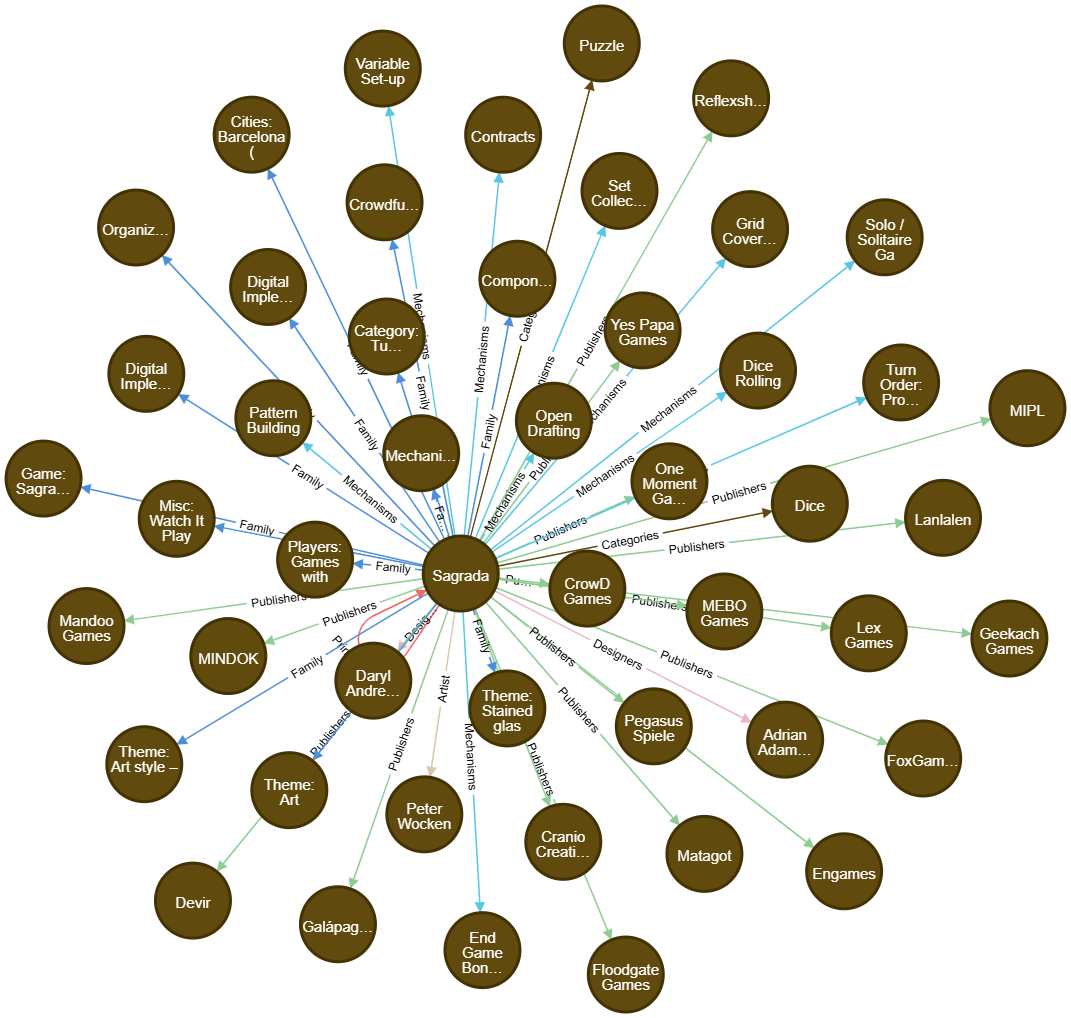

## 5. Generar interfaz

En nuestro dataset la respuesta se obtendría con

In [ ]:
df_relaciones[df_relaciones['RELACION'] == 'Publishers']

,SUJETO1,RELACION,SUJETO2
4,Sagrada,Publishers,Floodgate Games
5,Sagrada,Publishers,Cranio Creations
6,Sagrada,Publishers,CrowD Games
7,Sagrada,Publishers,Devir
8,Sagrada,Publishers,Engames
9,Sagrada,Publishers,FoxGames
10,Sagrada,Publishers,Galápagos Jogos
11,Sagrada,Publishers,Geekach Games
12,Sagrada,Publishers,Lanlalen
13,Sagrada,Publishers,Lex Games


pero con el llm en cypher quedaría algo así

In [ ]:
import json

In [ ]:
response_relaciones = client.models.generate_content(
    model="gemini-2.5-flash",
    # system_instruction should be a list of Parts
    config=types.GenerateContentConfig(system_instruction=json.dumps(consultas_cephyr, indent=2)),
    contents="Who are the publishers of Sagrada?. Show me the filters to find that answer"
)

In [ ]:
response_relaciones.text

"The publishers of Sagrada are:\n\n*   Floodgate Games\n*   Cranio Creations\n*   CrowD Games\n*   Devir\n*   Engames\n*   FoxGames\n*   Galápagos Jogos\n*   Geekach Games\n*   Lanlalen\n*   Lex Games\n*   Mandoo Games\n*   Matagot\n*   MEBO Games\n*   MINDOK\n*   MIPL\n*   One Moment Games\n*   Pegasus Spiele\n*   Reflexshop\n*   Yes Papa Games\n\n**Filters to find this answer:**\n\nTo find this information in a graph database, you would typically use a query that looks for nodes connected to 'Sagrada' via a 'Publishers' relationship.\n\nIn Cypher (Neo4j's query language), the query would be:\n\n```cypher\nMATCH (sagrada:Sujeto {name: 'Sagrada'})-[:Publishers]->(publisher:Sujeto)\nRETURN publisher.name AS Publisher\n```"

En la interfaz entonces, el usuario le pasará la consulta cómo quién publicó, quién diseño, que juegos diseño x? y el llm devolverá la consulta en Cypher

In [ ]:
def interfaz_relaciones(consulta, instructions):

  response_relaciones = client.models.generate_content(
    model="gemini-2.5-flash",
    # system_instruction con las queries filtradas
    config=types.GenerateContentConfig(system_instruction=instructions),
    contents=f"{consulta}. Show me ONLY the filters to find that answer"
)
  return response_relaciones.text

In [ ]:
instructiones = json.dumps(consultas_cephyr, indent=2)
consulta = "Who are the artists of Sagrada?"

In [ ]:
interfaz_relaciones(consulta, instructiones)

"To find the artists of Sagrada, you would apply the following filters:\n\n1.  **Node Label:** `Sujeto`\n2.  **Node Property:** `name` equal to 'Sagrada'\n3.  **Relationship Type:** `Artist` (outgoing from 'Sagrada')\n4.  **Target Node Label:** `Sujeto`"

La interfaz devuelve únicamente la query en Cypher para correrla directamente en neo4j

# Clasificador de Intención Avanzado:

1. Importar el modelo entrenado en el punto 6 del TP1P2.

2. Instanciar el Clasificador basado en LLM con Few-Shot Prompting.

3. Comparar ambos clasificadores (el entrenado y el basado en LLM)

4. Seleccionar el mejor.


## 1. Importar el modelo
Previamente, descargué el modelo y lo subí al repositorio de la materia

In [ ]:
import tensorflow.keras as tf_keras

In [ ]:
modelo_entrenado = tf_keras.models.load_model('//content/sagrada/NLP-2025/modelo_preguntas.keras')

In [ ]:
pd.read_csv("/content/sagrada/NLP-2025/dataset_preguntas.csv")

,pregunta,etiqueta
0,¿Qué empresa diseñó el empaque del juego?,relaciones
1,¿Qué celebridades han jugado Sagrada?,relaciones
2,¿Qué porcentaje de jugadores recomiendan Sagrada?,estadisticas
3,¿Qué puesto ocupa Sagrada en el ranking global...,estadisticas
4,¿Quién ganó el torneo nacional de Sagrada en 2...,relaciones
...,...,...
496,¿Cuántos países han participado en torneos de ...,estadisticas
497,¿Cómo se usan las cartas de objetivo oculto?,informacion
498,¿Qué tipos de restricciones se deben seguir al...,informacion
499,¿Cuántas ediciones del juego Sagrada existen?,estadisticas


2. Instaciamos el modelo LLM que actuará como clasificador al entrenarlo con Few-Shot Prompting

In [ ]:
prompt="\n\
SOLAMENTE Clasifica las siguientes preguntas en las posibles categorías donde estará la información: relaciones, estadísticas o información:\n\
Ejemplo 1:\n\
¿Qué celebridades han jugado Sagrada?: relaciones\n\
Ejemplo 2:\n\
¿Qué porcentaje de jugadores recomiendan Sagrada? // estadísticas\n\
Ejemplo 3:\n\
¿Cómo se eligen los dados al inicio del juego?//informacion"

preguntas_ddtaset = "¿Quién reseñó el juego Sagrada en YouTube?, ¿Cómo se eligen los dados al inicio del juego?, ¿Qué puesto ocupa Sagrada en el ranking global de BoardGameGeek? "
response_preguntas_avanzado = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt + preguntas_ddtaset

)


3. Comparamos las respuestas al pasarle las siguientes preguntas que sí estan en el dataset:

*   ¿Quién reseñó el juego Sagrada en YouTube? // **relaciones**
*   ¿Cómo se eligen los dados al inicio del juego? // **información**
*   ¿Qué puesto ocupa Sagrada en el ranking global de BoardGameGeek? // **estadísticas**

preguntas que no estan en el dataset

* ¿Cuántos dados se necesitan para jugar? --> Info
* ¿Cuánto vale el récord máximo en Sagrada? --> estad
* ¿Quienes pueden jugar Sagrada? --> info
* ¿Qué distribuidora distribuye el juego en Argentina? --> rela

In [ ]:
# Respuestas a preguntas en el dataset LLM:
print("Respuestas LLM con Few-Shot:\n" + response_preguntas_avanzado.text)

Respuestas LLM con Few-Shot:
*   ¿Quién reseñó el juego Sagrada en YouTube? // **relaciones**
*   ¿Cómo se eligen los dados al inicio del juego? // **información**
*   ¿Qué puesto ocupa Sagrada en el ranking global de BoardGameGeek? // **estadísticas**


Al LLM le bastó solo 1 ejemplo de cada categoria para responder bien a las preguntas.

Como los modelos keras no entienden texto directamente, entonces debo vectorizar las preguntas y luego pasarselas para que puedan interpretarlas

In [ ]:
import numpy as np


In [ ]:
def preguntar_modelo_entrenado(preguntas):
  clases = {0: "estadísticas", 1: "informacion", 2: "relaciones"}

  pregunta_embdd = model.encode(sentences=preguntas, show_progress_bar=True, convert_to_tensor=True).cpu().numpy()

  predicciones = modelo_entrenado.predict(pregunta_embdd)

  for idx, pregunta in enumerate(preguntas):

    clase_predicha = np.argmax(predicciones[idx])

    print(f"Pregunta: {pregunta}, Clase predicha: {clases[clase_predicha]}")

In [ ]:
preguntar_modelo_entrenado(['¿Quién reseñó el juego Sagrada en YouTube?','¿Cómo se eligen los dados al inicio del juego?','¿Qué puesto ocupa Sagrada en el ranking global de BoardGameGeek?' ])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Pregunta: ¿Quién reseñó el juego Sagrada en YouTube?, Clase predicha: relaciones
Pregunta: ¿Cómo se eligen los dados al inicio del juego?, Clase predicha: informacion
Pregunta: ¿Qué puesto ocupa Sagrada en el ranking global de BoardGameGeek?, Clase predicha: estadísticas


El modelo entrenado tambien logra responder correctamente las categorias de las preguntas que estaban en el dataset. Ahora probaré de pasarle preguntas que NO estaban en el dataset para hacer una comparación un poco mas justa con el llm que no estuvo entrenado con el dataset.


In [ ]:
preguntas_NOdtaset = "¿Con cuántos dados se juega?,  ¿Cuál es el récord máximo en Sagrada?, ¿Quienes pueden jugar Sagrada?, ¿Qué distribuidora distribuye el juego en Argentina?"

In [ ]:
preguntar_modelo_entrenado(preguntas_NOdtaset.split(', '))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Pregunta: ¿Con cuántos dados se juega?, Clase predicha: informacion
Pregunta:  ¿Cuál es el récord máximo en Sagrada?, Clase predicha: estadísticas
Pregunta: ¿Quienes pueden jugar Sagrada?, Clase predicha: relaciones
Pregunta: ¿Qué distribuidora distribuye el juego en Argentina?, Clase predicha: relaciones


Al pasarle preguntas que nunca vio, falla en las categorias de relaciones e información.

Veamos como clasifica estas preguntas el LLM

In [ ]:
prompt="\n\
SOLAMENTE Clasifica las siguientes preguntas en las posibles categorías donde estará la información: relaciones, estadísticas o información:\n\
Ejemplo 1:\n\
¿Qué celebridades han jugado Sagrada?: relaciones\n\
Ejemplo 2:\n\
¿Qué porcentaje de jugadores recomiendan Sagrada? // estadísticas\n\
Ejemplo 3:\n\
¿Cómo se eligen los dados al inicio del juego?//informacion"


response_preguntas_avanzado_NOdtaset = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt + preguntas_NOdtaset

)

In [ ]:
print(response_preguntas_avanzado_NOdtaset.text)

Aquí están las clasificaciones de las preguntas:

*   ¿Con cuántos dados se juega? // información
*   ¿Cuál es el récord máximo en Sagrada? // estadísticas
*   ¿Quiénes pueden jugar Sagrada? // información
*   ¿Qué distribuidora distribuye el juego en Argentina? // relaciones


El LLM acierta el 100% de las categorías haciendolo mas eficiente que el modelo entrenado

# Pipeline de Recuperación (Retrieval)

Por un lasdo, en esta etapa mejoraré las funciones definidas en los pasos de la creción de base de datos vectorial con la información de los textos implementando:
- Búsqueda híbrida = Búsqueda semántica por keyword + ReRank.

Por el otro, para la base de datos de grafos y datos tabulares:
- Prompt de usuar --> Filtro Pandas + Query Cypher



In [ ]:
## Interfaz creada anteriormente:
#def encontrar_textos_para_query(consulta: str , cantidadtextos: int):
#
#  query = consulta
#
#  # Búsqueda en la BDD vectorial
#  retrieved_docs = vector_store.similarity_search(query, k=cantidadtextos)
#
#  for num, d in enumerate(retrieved_docs):
#      print(f"Doc number: {num+1}")
#      print(d.page_content)
#      print("Metadata:")
#      print(d.metadata)
#      print("-"*100)




In [ ]:
!pip install txtai

In [ ]:
from txtai.scoring import ScoringFactory

In [ ]:
def pipeline_retrical_textos_para_query_hibrida(consulta: str, view=False):

  documentos_cercanos=[]

  # Búsqueda en la BDD vectorial, nos traemos los primeros 15 texto mas cercanos en el espacio vectorial
  retrieved_docs = vector_store.similarity_search(consulta, k=15)

  for d in retrieved_docs:
    documentos_cercanos.append(d.page_content)


  # Crear un índice BM25
  scoring = ScoringFactory.create({"method": "bm25", "terms": True})
  scoring.index(((x, texto, None) for x, texto in enumerate(documentos_cercanos)))

  resultados = scoring.search(consulta, 1)
  coincidencia = documentos_cercanos[resultados[0][0]] if resultados else "Sin resultados"

  if view:
    #Mostramos resultados en pantalla
    # Obtener el índice de la sección que mejor coincide con la consulta
    print("%-20s %s" % ("Consulta", "Mejor coincidencia"))
    print("-" * 50)
    print("%-20s %s" % (consulta, coincidencia))

  return coincidencia


In [ ]:
pipeline_retrical_textos_para_query_hibrida("Can kids play Sagrada?", view=True)

Consulta             Mejor coincidencia
--------------------------------------------------
Can kids play Sagrada? and you're gonna have to
use your tools at that point the only
thing that I don't like about the game
and this may just be me is that I feel
like after you've played this game I
don't know four or five times you will
have seen everything that you possibly
can see there's only 12 tools there's
five public objectives all our private
objectives all the private objectives
are four colors so there's no variance
and that other than trying to meet a
very specific color and then there are
ten public objectives I feel like with
one media expansion that allows for more
variety and your private objectives it
could be a very good game I would agree
with the fact that it's right for
expansion

yes like you could just
continually come out with more
windowpane guards more tools all sorts
of different things
I still think though at the end of the
day the game while some of those
variable e

"and you're gonna have to\nuse your tools at that point the only\nthing that I don't like about the game\nand this may just be me is that I feel\nlike after you've played this game I\ndon't know four or five times you will\nhave seen everything that you possibly\ncan see there's only 12 tools there's\nfive public objectives all our private\nobjectives all the private objectives\nare four colors so there's no variance\nand that other than trying to meet a\nvery specific color and then there are\nten public objectives I feel like with\none media expansion that allows for more\nvariety and your private objectives it\ncould be a very good game I would agree\nwith the fact that it's right for\nexpansion\n\nyes like you could just\ncontinually come out with more\nwindowpane guards more tools all sorts\nof different things\nI still think though at the end of the\nday the game while some of those\nvariable elements can you can get\nthrough in a few games pretty easily the\ngame itself because 

In [ ]:
def categorizacion_con_llm(pregunta):
  prompt="\n\
  SOLAMENTE devuelve el valor clasificado y  Clasifica las siguientes preguntas en las posibles categorías donde estará la información: relaciones, estadísticas o información:\n\
  Ejemplo 1:\n\
  ¿Qué celebridades han jugado Sagrada?: relaciones\n\
  Ejemplo 2:\n\
  ¿Qué porcentaje de jugadores recomiendan Sagrada? // estadísticas\n\
  Ejemplo 3:\n\
  ¿Cómo se eligen los dados al inicio del juego?//informacion"

  response_preguntas_avanzado = client.models.generate_content(
      model="gemini-2.5-flash",
      contents=prompt + pregunta

  )
  return response_preguntas_avanzado.text

In [ ]:
def pipeline_retrival_grafos(consulta):

    # Evaluar si la consulta esta semanticamente relacionada con relaciones o estadísticas, aprovechando el modelo LLM de los puntos anteriores
    response_categoria = categorizacion_con_llm(consulta)
    additional_info = ""
    motor = "Pandas"
    pd_info =  ""
    valores_info = ""
    valores_info_categorias = ""

    if response_categoria == "relaciones":
      motor = "Cypher y Pandas"
      aditional_info = "Sagrada is always the value of SUJETO1"
      pd_info = df_relaciones.columns
      valores_info = df_relaciones['RELACION'].unique()


    if response_categoria == "estadísticas":
      motor = "Pandas"
      pd_info =  df_estadísticas.columns
      valores_info= df_estadísticas['Metric'].unique()
      valores_info_categorias = df_estadísticas['Category'].unique()
      additional_info = f"The template should be compound search the category and the metric:"

    elif  response_categoria == "informacion":
      raise ValueError(f'La consulta no corresponde a dato tabular. Fue clasificada como {response_categoria} ')
      return

    response_relaciones = client.models.generate_content(
      model="gemini-2.5-flash",

      # system_instruction con las queries filtradas
      config=types.GenerateContentConfig(system_instruction="Just give the answer do not explain"),
      contents=f"{consulta}. Generate the correspoding {motor} filter depending on the dataframe with the columns {pd_info} and the unique values of those columns being {valores_info}. {additional_info}, with the right value for {valores_info_categorias} "
    )

    return response_relaciones.text


In [ ]:
print(pipeline_retrival_grafos('Quienes crearon sagrada'))

**Cypher:**
```cypher
MATCH (game:PrimaryName {name: 'Sagrada'})-[:Designers]->(designer)
RETURN designer.name
```

**Pandas Filter:**
```python
df[(df['SUJETO1'] == 'Sagrada') & (df['RELACION'] == 'Designers')]['SUJETO2']
```


In [ ]:
df_relaciones[(df_relaciones['SUJETO1'] == 'Sagrada') & (df_relaciones['RELACION'] == 'Designers')]['SUJETO2']

,SUJETO2
1,Adrian Adamescu
2,Daryl Andrews


In [ ]:
print(pipeline_retrival_grafos('Cuantos comentarios tiene el juego?'))

`(df['Category'] == 'GAME STATS') & (df['Metric'] == 'Comments')`


In [ ]:
df_estadísticas[(df_estadísticas['Category'] == 'GAME STATS') & (df_estadísticas['Metric'] == 'Comments')]

,Category,Metric,Value
4,GAME STATS,Comments,6137.0


# Integrar para la Generación y Conversación:
1. Definir el modo de integración de los componentes:
clasificador + recuperadores + un LLM generador
categorizacion_con_llm(pregunta) + pipeline_retrival_grafos/pipeline_retrical_textos_para_query_hibrida

Para eso crearé una funcion para procesar mi query, agregarle contexto y luego pasarsela al chat: process_query_with_rag

2. Crear el bucle conversacional con memoria para mantener el contexto de la conversarcion. Si no encuentra información relevante, el LLM debe generar una respuesta sugiriendo al usuario reformular su pregunta.


Como las interface ya fueron creadas en los puntos anteriores.Ahora tengo que implementar el LLM que tenga memoria y luego integrarlas

In [ ]:
!pip install langchain_google_genai

In [ ]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [ ]:


#
#
#
#    if info_econtrada:
#        prompt += f"usa la siguiente informacion para responder:\n{info_econtrada} Respondé solo con información del contexto. Si no está, indicá que no se encontró nada relacionado.\n\n"
#    else:
#        # Handle case where no relevant information is found
#        prompt += "No relevant information found. Reformulate your question\n\n"
#
#    prompt += f"Chat history:\n{chat_history}\n\n"
#    prompt += "Bot response:"
#
#    # 3. Generate the response using the LLM
#    response = llm.predict(prompt)
#
#    # 4. Update the memory
#    memory.save_context({"input": query}, {"output": response})
#
#    return response, retrieved_info

In [ ]:
import re

def consultar_filtro_pandas_relaciones(texto_filtro: str, df_relaciones: pd.DataFrame) -> str:
    """
    Evalúa el código de filtro pandas devuelto por el modelo si está presente en la respuesta.
    """
    # Buscar bloque de código en triple backticks o inline
    match = re.search(r"```python\s+(.*?)```", texto_filtro, re.DOTALL)
    if not match:
        match = re.search(r"(df\[.*\])", texto_filtro, re.DOTALL)

    if match:
        codigo = match.group(1).strip()
        try:
            resultado = eval(codigo, {"df": df_relaciones})
            if resultado.empty:
                return "No se encontraron resultados."
            return resultado.to_string(index=False)
        except Exception as e:
            return f"Error al ejecutar el filtro generado: {e}"
    else:
        return "No se detectó un código válido de pandas en la respuesta."


In [ ]:
def consultar_filtro_pandas_estadisticas(codigo_str, df_pass=df_estadísticas):
    """
    Evalúa un filtro pandas devuelto por el modelo sobre el DataFrame df_estadísticas.
    Puede ser una condición booleana o una expresión completa.
    """
    try:
        # Limpia espacios y backticks
        codigo_str = codigo_str.strip().strip("`")


        codigo_eval = codigo_str.replace("df", "df_estadísticas")

        # Detecta si es una expresión completa (ya incluye df[...] o df_estadísticas[...])
        if not codigo_eval.startswith("df_estadísticas["):
          codigo_eval = f"df_estadísticas[{codigo_eval}]"

        print(f"Query a ejecutar: {codigo_eval}")

        # Evalúa el código con df_estadísticas disponible
        resultado = eval(codigo_eval, {"df_estadísticas": df_pass})

        if resultado.empty:
            return "No se encontraron resultados"

        valor = resultado["Value"].values
        return valor[0] if len(valor) == 1 else valor.tolist()

    except Exception as e:
        return f"Error al evaluar el filtro: {e}"


In [ ]:
consultar_filtro_pandas_estadisticas("df[(df['Category'] == 'GAME STATS') & (df['Metric'] == 'Comments')]")

Query a ejecutar: df_estadísticas[(df_estadísticas['Category'] == 'GAME STATS') & (df_estadísticas['Metric'] == 'Comments')]


np.float64(6137.0)

In [ ]:
load_dotenv()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_retries=2,
    google_api_key=userdata.get("GEMINI_TOKE")
)


In [ ]:
def process_query_with_rag(query, memory, resumen):

    # 1. Categorizamos la pregunta
    category = str(categorizacion_con_llm(query))
    print(f"La categoria es: {category}")

    # 2. Obtenemos la información relevante según categoría
    if category in ['información', 'informacion']:
        info_econtrada = pipeline_retrical_textos_para_query_hibrida(query)
    elif category in ['estadísticas', 'estadisticas']:
        info_econtrada = pipeline_retrival_grafos(query)
        info_econtrada = consultar_filtro_pandas_estadisticas(info_econtrada, df_estadísticas)
    elif category == 'relaciones':
        info_econtrada = pipeline_retrival_grafos(query)
        info_econtrada = consultar_filtro_pandas_relaciones(info_econtrada, df_relaciones)
    else:
        info_econtrada = "No se pudo determinar la categoría de la consulta."


    # 3. Contextualizamos la info para el prompt
    if isinstance(info_econtrada, (int, float, str)):
        contexto = f"La información solicitada es: {info_econtrada}."
    else:
        contexto = str(info_econtrada)

    # 4. Incluimos el historial si existe y armamos el prompt completo
    chat_history = memory.load_memory_variables({}).get('chat_history', '')

    prompt = (
        f"{chat_history}\n\n"
        f"User query: {query}\n\n"
        f"Usa la siguiente información para responder:\n{contexto}\n"
        "Respondé solo interpretándola. Si no está, indicá que no se encontró nada relacionado.\n\n"
    )

    #print("Prompt enviado al modelo:\n", prompt)

    # 5. Generamos la respuesta con el LLM
    response = llm.predict(prompt)
    return response


In [ ]:
# Initialize memory and conversation chain
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=llm,
    memory=memory,
    verbose=False
)

/tmp/ipython-input-87-2739318404.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()
/tmp/ipython-input-87-2739318404.py:3: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use :class:`~langchain_core.runnables.history.RunnableWithMessageHistory` instead.
  conversation = ConversationChain(


Evaluamos el propmt por fuera del bucle consersacional para interpretar como usa el contexto el chat

In [ ]:
test_prompt = f"User query: Quien diseño Sagrada\n\n"

In [ ]:
llm.predict(test_prompt)

/tmp/ipython-input-89-4221082933.py:1: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  llm.predict(test_prompt)


'El arquitecto más conocido y el que le dio su forma distintiva a la **Sagrada Familia** es **Antoni Gaudí**.\n\nSin embargo, es importante saber que el diseño original no fue suyo. La primera piedra se colocó en 1882 bajo la dirección del arquitecto **Francisco de Paula del Villar y Lozano**.\n\nVillar renunció poco después, y en 1883, **Antoni Gaudí** asumió el proyecto. Gaudí transformó completamente el diseño inicial, dedicando las últimas décadas de su vida exclusivamente a la Sagrada Familia y dándole la visión y el estilo modernista que hoy conocemos.\n\nDesde la muerte de Gaudí en 1926, varios arquitectos han continuado su obra, siguiendo sus planos y maquetas, aunque la interpretación de su visión ha sido un tema de debate.'

En una primer instancia, el chat no respondió directamente acerca del juego sino de la Sagrada Basilica. Veremos como responde con el contexto adecuado en la conversación.

In [ ]:
print("Conversación iniciada. Escribí 'exit' para salir.\n")

while True:
    user_input = input("")
    if user_input.lower() == "exit":
        break

    respuesta = process_query_with_rag(user_input, memory, resumen)

    print(f"Asistente: {respuesta}\n")


Conversación iniciada. Escribí 'exit' para salir.

Cuantos comentarios tiene Sagrada?
La categoria es: estadísticas
Query a ejecutar: df_estadísticas[(df_estadísticas['Category'] == 'GAME STATS') & (df_estadísticas['Metric'] == 'Comments')]
Asistente: Sagrada tiene 6137 comentarios.

Los niños pueden jugar?
La categoria es: informacion
Asistente: No se encontró información relacionada con si los niños pueden jugar en el texto proporcionado. El texto se centra en las reglas de puntuación y el modo solitario del juego.

Can kids play?
La categoria es: informacion
Asistente: Sí, los niños pueden jugar. El texto menciona que es un juego muy accesible y que "cualquiera podría jugarlo". Específicamente, se dice que "un niño de ocho años que obviamente sepa leer podría jugar a este juego". También se destaca que es una gran oportunidad para enseñar a los niños las sutilezas del juego.

Cuando termina la partida?
La categoria es: informacion
informacion
Asistente: No se encontró nada relaciona

Consulta dinamicamenta la tabla de los datos, y responde acorde. Uno de los mayores desafíos es que la clasificación de la preguntas no funcione correctamente aunque esto es algo inherente de las preguntas ya que la categorizacipon depende de como se tenga estrucuturada la información. Si el contexto que encontró está en inglés el chat no logra interpretarl a consulta, pero al pasarle la traduccion de la query, logra responder y en español. Un analisis mas profundo y con mayores datos, se encuentra en el informe. Preguntas del input:

* Cuantos comentarios tiene Sagrada?
* Los niños pueden jugar?
* Can kids play?
* Cuando termina la partida?
* Cuando termina el juego?
* Cuantos jugadores pueden jugar?
* De a cuantos jugadores se puede jugar?
* Quienes diseñaron sagrada?
* Quienes crearon sagrada?


# Agregar conclusion del ejercicio 1

# Ejercicio 2 - Evolución del RAG a un Agente Autónomo



Utilizar Langchain para implementar un agente basado en el paradigma ReAct.
Creación de Herramientas (Tools):

Encapsula la lógica de búsqueda de cada fuente de datos del Ejercicio 1 en herramientas independientes:

doc_search(): Busca en los documentos de texto (con búsqueda híbrida y re-rank).
table_search(): Realiza consultas dinámicas a los datos tabulares.
graph_search(): Realiza consultas dinámicas a la base de datos de grafos.

Adicionalmente, implementa una cuarta herramienta de búsqueda online utilizando las integraciones de Langchain:

wikipedia_search(): Para búsqueda en una enciclopedia libre.
duckduckgo_search(): Para búsquedas en internet.

Construye un prompt de sistema cuidadosamente diseñado que le indique al agente el propósito de cada herramienta y cómo debe razonar (Thought) para elegir una o varias herramientas (Action) y así construir una respuesta completa.


In [ ]:
!pip install -U duckduckgo-searchv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.9 MB/s eta 0:00:00


In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=b737ef94496ccc28374a649d74d06f4aff1d40e2d8288555a887988549b67fe3
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [ ]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun

In [ ]:
def doc_search(query):
  return pipeline_retrical_textos_para_query_hibrida(query, view=False)

In [ ]:
def table_search(query):
  return pipeline_retrival_grafos(query)

In [ ]:
def graph_search(query):
  return pipeline_retrival_grafos(query)

In [ ]:
def wikipedia_search(query):
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(query)

In [ ]:
def duckduckgo_search(query):
    return DuckDuckGoSearchRun().run(query)

In [ ]:
prompt_ReAct = """Sos un asistente que responde preguntas utilizando múltiples fuentes de datos.

Temes que elegir la herramienta mas adecuada para responder correctamente, usando el siguiente razonamiento:

herramientas locales, las cuales debes consultar primero:
1. doc_search: para buscar información en documentos textuales (reglas de juego, manuales, textos extensos). Usa esta herramienta cuando el usuario busque definiciones, reglas, descripciones o informacion.
2. table_search: para obtener estadísticas, métricas o datos numéricos. Usá esta herramienta si la consulta menciona cantidades, rankings, puntuaciones, comentarios, etc. y existan los resultados de dichas queries
3. graph_search: para explorar relaciones entre entidades como juegos, diseñadores, categorías, editoriales."


herramientas externas, si la información necesaria para responder no fue encontrada:
4. wikipedia_search: para obtener contexto general sobre temas conocidos del mundo real. Usala cuando el usuario pregunte sobre un concepto amplio o externo al dominio interno.
5. duckduckgo_search: para buscar en toda la web, UNICAMENTE cuando ninguna otra herramienta da buenos resultados.

procedimiento:
1. Pensa (Thought) que tipo de información se requiere.
2. Elegi (Action) una herramienta local basándote en el tipo de datos necesario.
3. Ejecutá las herramienta elegida.
4. Si la información no es relevante para responder entonces elegi alguna herramienta externa
5. Ejecuta la herramienta externa.
6. Usá los resultados para construir una respuesta clara.

"""


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm_react = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    convert_system_message_to_human=True  # respetar el prompt de sistema
)


In [ ]:
from langchain.agents import Tool

tools = [
    Tool(name="doc_search", func=doc_search, description="Busca en los documentos textuales"),
    Tool(name="table_search", func=table_search, description="Consulta estadísticas numéricas"),
    Tool(name="graph_search", func=graph_search, description="Consulta relaciones entre juegos, autores, etc."),
    Tool(name="wikipedia_search", func=wikipedia_search, description="Busca información enciclopédica"),
    #Tool(name="duckduckgo_search", func=duckduckgo_search, description="Busca en toda la web"),
]


In [ ]:
from langchain.agents import initialize_agent
from langchain.agents.agent_types import AgentType


agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    agent_kwargs={"system_message": prompt_ReAct}
)


In [ ]:
respuesta = agent.run("Los daltinicos pueden jugar Sagrada?")
print(respuesta)




> Entering new AgentExecutor chain...
Action: wikipedia_search
Action Input: Sagrada board game

/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')



Observation: Page: Sagrada (board game)
Summary: Sagrada is a dice-drafting board game designed by Adrian Adamescu and Daryl Andrews and published in 2017 by Floodgate Games. Each player constructs a stained-glass window using dice on a personal 4×5 game board board with restrictions on the types of dice that can be played on each space. Players gain points by completing public and secret objectives for dice placements, and the one with the most after ten rounds is the winner.

Page: Board game
Summary: A board game is a type of tabletop game that involves small objects (game pieces) that are placed and moved in particular ways on a specially designed patterned game board, potentially including other components, e.g. dice. The earliest known uses of the term "board game" are between the 1840s and 1850s.
While game boards are a necessary and sufficient condition of this genre, card games that do not use a standard deck of cards, as well as games that use neither cards nor a game board,